# Decision Trees & Random Forests

In this notebook we will first explore the implementation, complexity and high variability of decision tree models. Then we will introduce random forests, which offer decreased variance at the cost of being less intuitive.

At the root of machine learning is the bias-variance tradeoff. Decision trees, which learn the training data very well, are unable to generalize to new data; they are said to have high variance. Contrast this to a simple model with high bias that is unable to learn the training data. Random forests seek to reduce the variance of a decision tree while accurately learning the training data.

Decision trees are a simple flowchart-based model that attempts to minimize Gini impurity when splitting at each node. Random forests consist of hundreds to thousands of individual decisions trees that are trained on different sets of observations (bootstrapping). At each node, a subset of features are used to split the tree. Average voting across trees is used to make predictions.

Note that for imbalanced datasets such as this one, accuracy is not an appropriate metric. Instead, we use Reciever Operating Characteristic Area Under the Curve (ROC AUC).

Dataset used: https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system (2015)

In [143]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [114]:
SEED = 42

In [115]:
df = pd.read_csv("assets/2015.csv")
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,b'01292015',b'01',b'29',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
1,1.0,1.0,b'01202015',b'01',b'20',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,2.0
2,1.0,1.0,b'02012015',b'02',b'01',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
3,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,9.0
4,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0


In [116]:
df.shape

(441456, 330)

In [117]:
len(df.columns.values)

330

In [118]:
df = df.select_dtypes("number")
len(df.columns.values)

323

#### Re-assign target to 1 or 0, drop other values

In [119]:
target = '_RFHLTH'
df[target].value_counts()

1.0    358072
2.0     82137
9.0      1247
Name: _RFHLTH, dtype: int64

In [120]:
df[target] = df[target].replace({2: 0})
df[target].value_counts()

1.0    358072
0.0     82137
9.0      1247
Name: _RFHLTH, dtype: int64

In [121]:
df = df[df[target] <= 1]
df[target].value_counts()

1.0    358072
0.0     82137
Name: _RFHLTH, dtype: int64

#### Drop columns that are different versions of our target variable

In [122]:
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

#### Deal with missing values

In [123]:
df.isna().sum()

_STATE           0
FMONTH           0
DISPCODE         0
SEQNO            0
_PSU             0
CTELENUM    186394
PVTRESD1    186394
COLGHOUS    440165
STATERES    186396
CELLFON3    186393
LADULT      440165
NUMADULT    186419
NUMMEN      186536
NUMWOMEN    186537
CTELNUM1    253815
CELLFON2    253815
CADULT      253816
PVTRESD2    253815
CCLGHOUS    439142
CSTATE      253814
LANDLINE    254558
HHADULT     258989
PERSDOC2         0
MEDCOST          1
CHECKUP1         1
BPHIGH4          1
BPMEDS      262632
BLOODCHO         0
CHOLCHK      58915
TOLDHI2      58915
             ...  
PADUR1_     153041
PADUR2_     248194
PAFREQ1_    149625
PAFREQ2_    245837
_MINAC11    154814
_MINAC21    157112
STRFREQ_     43780
PAMISS1_         0
PAMIN11_    157736
PAMIN21_    160004
PA1MIN_     151753
PAVIG11_    152990
PAVIG21_    157349
PA1VIGM_    150319
_PACAT1          0
_PAINDX1         0
_PA150R2         0
_PA300R2         0
_PA30021         0
_PASTRNG         0
_PAREC1          0
_PASTAE1    

In [124]:
# Extract the labels
labels = np.array(df.pop(target))

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = SEED)

In [125]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# Features for feature importances
features = list(X_train.columns)

In [126]:
X_train.shape, X_test.shape

((308146, 313), (132063, 313))

#### Fit a decision tree

In [127]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [128]:
print("Decision Tree has {} nodes with max depth {}".format(tree.tree_.node_count, tree.tree_.max_depth))

Decision Tree has 54429 nodes with max depth 77


#### Assess performance for overfitting

In [129]:
dt_train_probs = tree.predict_proba(X_train)[:, 1]
dt_test_probs = tree.predict_proba(X_test)[:, 1]

dt_train_predictions = tree.predict(X_train)
dt_test_predictions = tree.predict(X_test)

In [130]:
print("Train ROC AUC Score: {}".format(roc_auc_score(y_train, dt_train_probs)))
print("Test ROC AUC Score: {}".format(roc_auc_score(y_test, dt_test_probs)))

Train ROC AUC Score: 1.0
Test ROC AUC Score: 0.6802190222196389


In [131]:
guess = [1 for p in range(len(y_test))]
print("Baseline ROC AUC Score: {}".format(roc_auc_score(y_test, guess)))

Baseline ROC AUC Score: 0.5


While the model outperforms baseline, it performs significantly worse on the test set than on the training set. This is evidence of overfitting.

In [174]:
def evaluate_model(train_predictions, train_probs, test_predictions, test_probs):
    guess = [1 for p in range(len(y_test))]
    baseline_results = {}
    baseline_results["recall"] = recall_score(y_test, guess)
    baseline_results["precision"] = precision_score(y_test, guess)
    baseline_results["roc"] = 0.5

    train_results = {}
    train_results["recall"] = recall_score(y_train, train_predictions)
    train_results["precision"] = precision_score(y_train, train_predictions)
    train_results["roc"] = roc_auc_score(y_train, train_probs)

    test_results = {}
    test_results["recall"] = recall_score(y_test, test_predictions)
    test_results["precision"] = precision_score(y_test, test_predictions)
    test_results["roc"] = roc_auc_score(y_test, test_probs)

    for metric in ["recall", "precision", "roc"]:
        print("{} -> baseline: {:0.2f}, train: {:0.2f}, test: {:0.2f}".format(metric, baseline_results[metric], train_results[metric], test_results[metric]))

    results = {
        "recall": [baseline_results["recall"], train_results["recall"], test_results["recall"]],
        "precision": [baseline_results["precision"], train_results["precision"], test_results["precision"]],
        "roc": [baseline_results["roc"], train_results["roc"], test_results["roc"]]
    }
    
    results_df = pd.DataFrame(results,
                              index=["baseline", "train", "test"],
                              columns=["recall", "precision", "roc"]).round(2)
    
    baseline_fpr, baseline_tpr, baseline_thresholds = roc_curve(y_test, guess)
    model_fpr, model_tpr, model_thresholds = roc_curve(y_test, test_probs)

    sns.set()
    plt.figure(figsize=(10,5))
    plt.plot(model_fpr, model_tpr, color='r', label="Model")
    plt.plot(baseline_fpr, baseline_tpr, color='b', label="Baseline")
    plt.title("Model ROC Curve vs. Baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    
    return results_df

recall -> baseline: 1.00, train: 1.00, test: 0.87
precision -> baseline: 0.81, train: 1.00, test: 0.88
roc -> baseline: 0.50, train: 1.00, test: 0.68


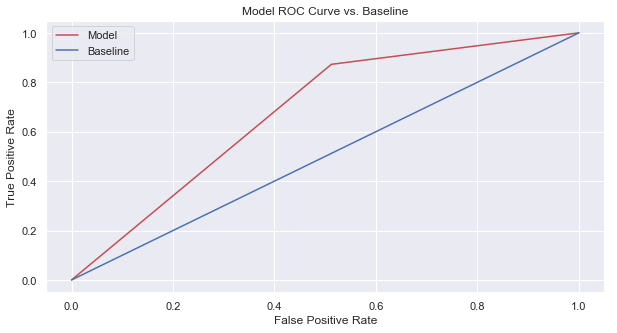

In [175]:
results_df = evaluate_model(dt_train_predictions, dt_train_probs, dt_test_predictions, dt_test_probs)

In [176]:
results_df

,recall,precision,roc
baseline,1.00,0.81,0.50
train,1.00,1.00,1.00
test,0.87,0.88,0.68


In [135]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

Normalized confusion matrix
[[0.49 0.51]
 [0.13 0.87]]


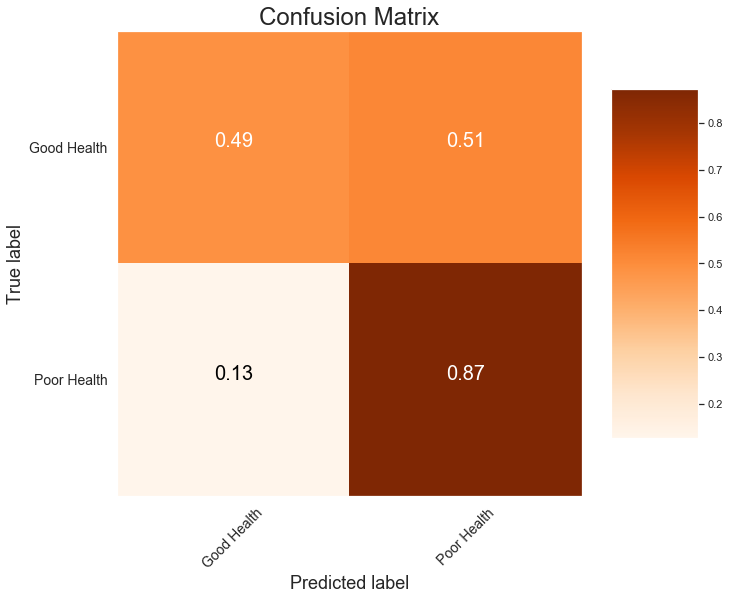

In [141]:
# Visualize results
cnf_matrix = confusion_matrix(y_test, dt_test_predictions)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=["Good Health", "Poor Health"], normalize=True, title="Confusion Matrix")

In [138]:
# Visualize feature importances
importances = pd.DataFrame({"Feature": features, "Importance":tree.feature_importances_}).sort_values("Importance", ascending=False)
importances.head()

,Feature,Importance
62,DIFFWALK,0.192191
58,QLACTLM2,0.031760
51,EMPLOY1,0.029991
54,INTERNET,0.016637
245,_BMI5,0.015268


#### Fit a random forest

The random forest ensembles hundreds or thousands of individual decision trees to reduce variance. Each tree is trained on a subset of observations and only a subset of features are used for making a split at each node. Random forests make predictions by averaging the predictions of each individual decision tree for each data point.

In [60]:
rf = RandomForestClassifier(n_estimators=100,
                            random_state=SEED,
                            max_features="sqrt",
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

We can interrogate the forest to determine the average number of nodes and maximum depth for each tree.

In [63]:
trees = rf.estimators_
print(len(trees))
trees[0]

100


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1608637542, splitter='best')

#### Examine the trees in the random forest

In [151]:
def rf_histograms(trees):
    num_nodes = []
    max_depth = []

    for t in trees:
        num_nodes.append(t.tree_.node_count)
        max_depth.append(t.tree_.max_depth)

    sns.set()
    print("Avg num nodes: {:.0f}, Avg max depth: {:.0f}".format(np.mean(num_nodes), np.mean(max_depth)))
    figure, ax = plt.subplots(1, 2, figsize=(10,5))

    sns.distplot(num_nodes, kde=False, ax=ax[0])
    sns.distplot(max_depth, kde=False, ax=ax[1])
    ax[0].set_title("Histogram of Node Count")
    ax[1].set_title("Histogram of Max Depth")
    plt.show()

Avg num nodes: 58485, Avg max depth: 56


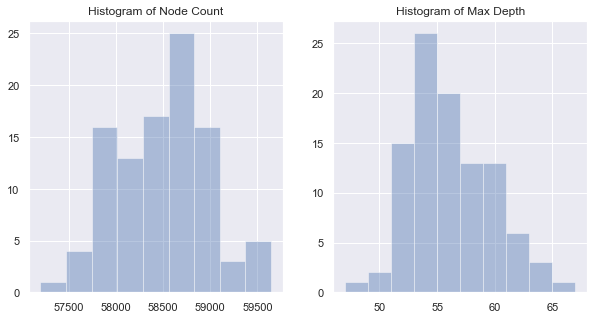

In [152]:
rf_histograms(trees)

#### Assess performance

The random forest model is able to generalize more than a single decision tree. This means that it performs better on unseen test data.

In [95]:
rf_train_predictions = rf.predict(X_train)
rf_train_probs = rf.predict_proba(X_train)[:,1]

rf_test_predictions = rf.predict(X_test)
rf_test_probs = rf.predict_proba(X_test)[:,1]

recall -> baseline: 1.00, train: 1.00, test: 0.96
precision -> baseline: 0.81, train: 1.00, test: 0.89
roc -> baseline: 0.50, train: 1.00, test: 0.88


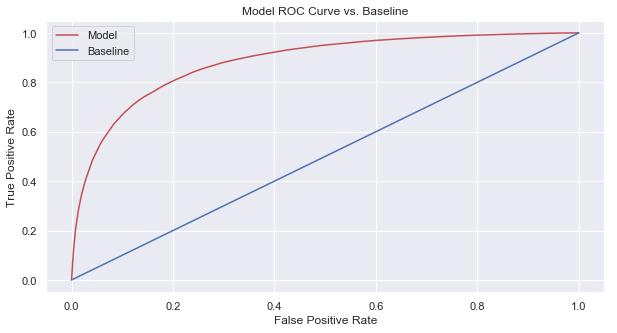

In [179]:
results_df = evaluate_model(rf_train_predictions, rf_train_probs, rf_test_predictions, rf_test_probs)

In [180]:
results_df

,recall,precision,roc
baseline,1.00,0.81,0.50
train,1.00,1.00,1.00
test,0.96,0.89,0.88


Normalized confusion matrix
[[0.47 0.53]
 [0.04 0.96]]


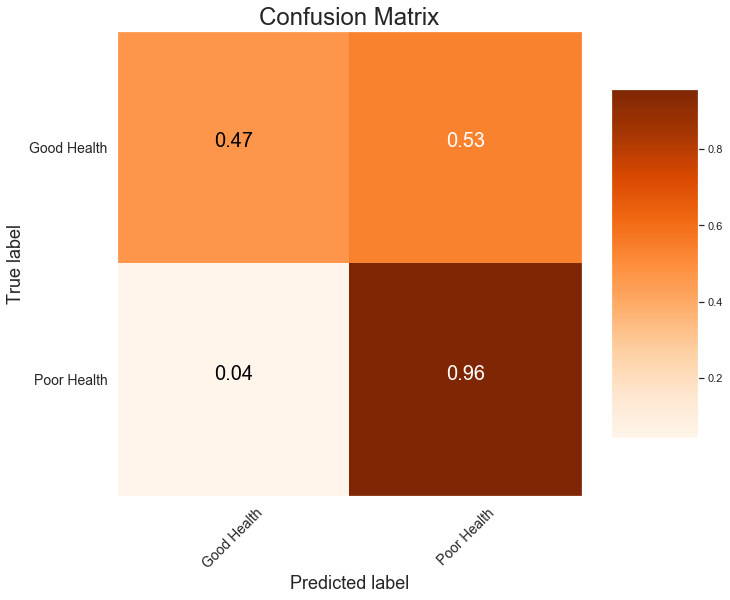

In [140]:
cnf_matrix = confusion_matrix(y_test, rf_test_predictions)

plot_confusion_matrix(cnf_matrix, classes=["Good Health", "Poor Health"], normalize=True, title="Confusion Matrix")

In [142]:
# Visualize feature importances
importances = pd.DataFrame({"Feature": features, "Importance":rf.feature_importances_}).sort_values("Importance", ascending=False)
importances.head()

,Feature,Importance
62,DIFFWALK,0.041086
58,QLACTLM2,0.031607
64,DIFFALON,0.022885
51,EMPLOY1,0.020929
59,USEEQUIP,0.017400


#### Tune hyperparameters

In [145]:
# Hyperparameters to tune
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

base = RandomForestClassifier(random_state=SEED)

# Create the random search model
rs = RandomizedSearchCV(base,
                        param_grid,
                        n_jobs=-1,
                        scoring='roc_auc',
                        cv=3,
                        n_iter=10,
                        verbose=1,
                        random_state=SEED)

# WARNING: this takes 40 mins
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 41.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, ...9, 49, 49, 49, 49, 49, 49, 49, 49, 50], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_job

#### Examine the optimal parameters
```
best_params = 
{'n_estimators': 157,
'min_samples_split': 2,
'max_leaf_nodes': 31,
'max_features': 'auto',
'max_depth': 14,
'bootstrap': True}
 ```

In [154]:
best_params = rs.best_params_
best_params

{'n_estimators': 157,
 'min_samples_split': 2,
 'max_leaf_nodes': 31,
 'max_features': 'auto',
 'max_depth': 14,
 'bootstrap': True}

#### Examine the trees in the best model

In [157]:
best_model = rs.best_estimator_
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=31,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=157, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Max depth: 14
Avg num nodes: 61, Avg max depth: 9


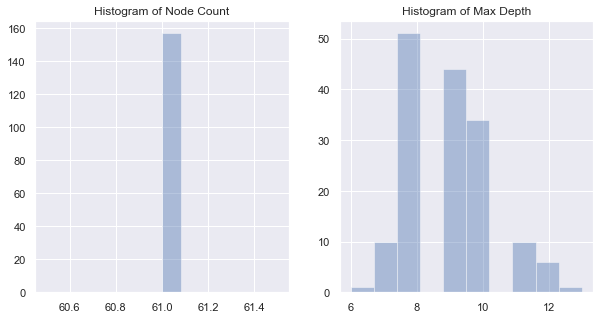

In [160]:
print("Max depth: {}".format(best_model.max_depth))
rf_histograms(best_model.estimators_)

#### Assess the performance of the best model

In [161]:
best_model_train_predictions = best_model.predict(X_train)
best_model_train_probs = best_model.predict_proba(X_train)[:, 1]

best_model_test_predictions = best_model.predict(X_test)
best_model_test_probs = best_model.predict_proba(X_test)[:, 1]

recall -> baseline: 1.00, train: 0.98, test: 0.98
precision -> baseline: 0.81, train: 0.86, test: 0.86
roc -> baseline: 0.50, train: 0.88, test: 0.87


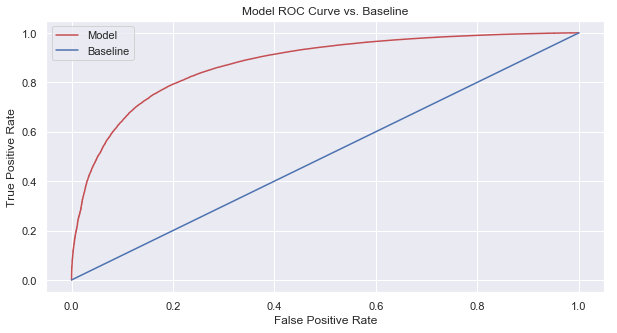

In [177]:
results_df = evaluate_model(best_model_train_predictions, best_model_train_probs, best_model_test_predictions, best_model_test_probs)

In [178]:
results_df

,recall,precision,roc
baseline,1.00,0.81,0.50
train,0.98,0.86,0.88
test,0.98,0.86,0.87


In this case, the optimal model performs about the same as the first random forest model that was trained. It could be that we have reached the maximum performance level for random forests for this particular application.